In [107]:
# Import the required libraries

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from datetime import datetime
from matplotlib.dates import DateFormatter
import xgboost as xgb
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV
import pprint



In [108]:
#controls 

#select if both april and may data are used for training
both_months = False

#select if log_rh is used instead of rh
log_rh = True

In [109]:
def remove_outliers(df, column_name):
    # Calculate the mean of the column
    mean_value = df[column_name].mean()
    std_dev = df[column_name].std()

    # Define the upper threshold (4 to 5 times the mean)
    upper_threshold = mean_value + (std_dev * 4)
    lower_threshold = mean_value - (std_dev * 4)

    # Filter the data and keep only rows with values within the threshold
    filtered_df = df[df[column_name] <= upper_threshold]
    filtered_df = filtered_df[filtered_df[column_name] >= lower_threshold]

    return filtered_df



In [110]:
parameters = [
    {'name': 'rh', 'label': 'Relative Humidity', 'unit': '%'},
    {'name': 'pm1', 'label': 'PM\u2081', 'unit': 'µg/m\u00b3'},
    {'name': 'pm25', 'label': 'PM\u2082.\u2085', 'unit': 'µg/m\u00b3'},
    {'name': 'pm10', 'label': 'PM\u2081\u2080', 'unit': 'µg/m\u00b3'},
    {'name': 'temp', 'label': 'Temperature', 'unit': '°C'}
]

In [111]:



dfMod_april = pd.read_csv('April_data/outdoor_april.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')
dfAlp_april = pd.read_csv('April_data/alpha_april.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')
dfBet_april = pd.read_csv('April_data/beta_april.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')

dfMod_may = pd.read_csv('May_data/outdoor_may.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')
dfAlp_may = pd.read_csv('May_data/alpha_may.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')
dfBet_may = pd.read_csv('May_data/beta_may.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')



if both_months:

    dfAlp = pd.concat([dfAlp_april,dfAlp_may])
    dfBet = pd.concat([dfBet_april,dfBet_may])
    dfMod = pd.concat([dfMod_april,dfMod_may])
else:
    dfAlp = dfAlp_may
    dfBet = dfBet_may
    dfMod = dfMod_may

dfAlp_april.rename(columns={'timestamp_local':'Date'},inplace=True)
dfBet_april.rename(columns={'timestamp_local':'Date'},inplace=True)
dfAlp_april.rename(columns={'sample_rh':'rh'},inplace=True)
dfBet_april.rename(columns={'sample_rh':'rh'},inplace=True)
dfAlp_april.rename(columns={'sample_temp':'temp'},inplace=True)
dfBet_april.rename(columns={'sample_temp':'temp'},inplace=True)
dfMod_april.index = dfMod_april.index.map(lambda x: x.replace(second=0))
dfAlp_april.index = dfAlp_april.index.map(lambda x: x.replace(second=0))
dfBet_april.index = dfBet_april.index.map(lambda x: x.replace(second=0))
dfAlp_april = remove_outliers(dfAlp_april,'pm10')
dfBet_april = remove_outliers(dfBet_april,'pm10')
dfMod_april = remove_outliers(dfMod_april,'pm10')

common_timestamps = dfMod_april.index.intersection(dfAlp_april.index).intersection(dfBet_april.index)

# Filter each DataFrame to keep only the rows with common timestamps
dfMod_april = dfMod_april[dfMod_april.index.isin(common_timestamps)]
dfAlp_april = dfAlp_april[dfAlp_april.index.isin(common_timestamps)]
dfBet_april = dfBet_april[dfBet_april.index.isin(common_timestamps)]

# for parameter in parameters:
#     max_Mod = dfMod_april[parameter['name']].max()
#     dfAlp_april[parameter['name']] = dfAlp_april[parameter['name']]/max_Mod
#     dfBet_april[parameter['name']] = dfBet_april[parameter['name']]/max_Mod
#     dfMod_april[parameter['name']] = dfMod_april[parameter['name']]/max_Mod

    
dfAlp.rename(columns={'timestamp_local':'Date'},inplace=True)
dfBet.rename(columns={'timestamp_local':'Date'},inplace=True)
dfAlp.rename(columns={'sample_rh':'rh'},inplace=True)
dfBet.rename(columns={'sample_rh':'rh'},inplace=True)
dfAlp.rename(columns={'sample_temp':'temp'},inplace=True)
dfBet.rename(columns={'sample_temp':'temp'},inplace=True)
dfMod.index = dfMod.index.map(lambda x: x.replace(second=0))
dfAlp.index = dfAlp.index.map(lambda x: x.replace(second=0))
dfBet.index = dfBet.index.map(lambda x: x.replace(second=0))


dfAlp = remove_outliers(dfAlp,'pm10')
dfBet = remove_outliers(dfBet,'pm10')
dfMod = remove_outliers(dfMod,'pm10')


OG_dfAlp = dfAlp.iloc[::-1]
OG_dfBet = dfBet.iloc[::-1]
OG_dfMod = dfMod.iloc[::-1]


OG_dfMod = OG_dfMod[OG_dfMod['pm10'] > 0]
OG_dfAlp = OG_dfAlp[OG_dfAlp['pm10'] > 0]   
OG_dfBet = OG_dfBet[OG_dfBet['pm10'] > 0]


OG_dfMod = OG_dfMod[OG_dfMod['pm25'] > 0]
OG_dfAlp = OG_dfAlp[OG_dfAlp['pm25'] > 0]   
OG_dfBet = OG_dfBet[OG_dfBet['pm25'] > 0]



OG_dfMod = OG_dfMod[OG_dfMod['pm1'] > 0]
OG_dfAlp = OG_dfAlp[OG_dfAlp['pm1'] > 0]   
OG_dfBet = OG_dfBet[OG_dfBet['pm1'] > 0]

common_timestamps = OG_dfMod.index.intersection(OG_dfAlp.index).intersection(OG_dfBet.index)

# Filter each DataFrame to keep only the rows with common timestamps
OG_dfMod = OG_dfMod[dfMod.index.isin(common_timestamps)]
OG_dfAlp = OG_dfAlp[dfAlp.index.isin(common_timestamps)]
OG_dfBet = OG_dfBet[dfBet.index.isin(common_timestamps)]

# for parameter in parameters:
#     max_Mod = OG_dfMod[parameter['name']].max()
#     OG_dfAlp[parameter['name']] = OG_dfAlp[parameter['name']]/max_Mod
#     OG_dfBet[parameter['name']] = OG_dfBet[parameter['name']]/max_Mod
#     OG_dfMod[parameter['name']] = OG_dfMod[parameter['name']]/max_Mod






print(len(OG_dfMod), len(OG_dfAlp), len(OG_dfBet))


print(.8*len(OG_dfAlp))
if both_months:
    train_slice = slice(5000,int(.8*len(OG_dfAlp)))
    test_slice = slice(int(.8*len(OG_dfAlp)),len(OG_dfMod))
    train_dfAlp = OG_dfAlp[5000:int(.8*len(OG_dfAlp))]
    train_dfBet = OG_dfBet[5000:int(.8*len(OG_dfAlp))]
    train_dfMod = OG_dfMod[5000:int(.8*len(OG_dfAlp))]

else:
    train_dfAlp = OG_dfAlp[:len(OG_dfMod)]
    train_dfBet = OG_dfBet[:len(OG_dfMod)]
    train_dfMod = OG_dfMod[:len(OG_dfMod)]

print(len(train_dfMod),len(train_dfAlp),len(train_dfBet))

44244 44245 44244
35396.0
44244 44244 44244


In [112]:
param_grid = {
    'max_depth': [5],
    'n_estimators': [40,60,70],
    'learning_rate': [ 0.05]

    
}


In [113]:
alpha_regressor = {}
beta_regressor = {}

def preprocess_data(df, parameter_name):
    df[parameter_name] = df[parameter_name].astype(float)
    df['temp'] = df['temp'].astype(float)
    df['rh'] = df['rh'].astype(float)
    if log_rh:
        df['log_rh'] = np.log(df['rh'])
        X = df[[parameter_name, 'temp', 'log_rh']]
    else:
        X = df[[parameter_name, 'temp', 'rh']]
    return X
def optimize_and_train_regressor(X, y, X_val, y_val):  # Add X_val and y_val parameter

    regressor = GridSearchCV(
        xgb.XGBRegressor(objective='reg:squarederror'),
        param_grid,
        cv=10,
        verbose=0,
        scoring='r2',
        refit='r2'
    )
    regressor.fit(X, y, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
    best_params = regressor.best_params_
 



    print(regressor.best_score_)
    best_regressor = xgb.XGBRegressor(**best_params)
    best_regressor.fit(X, y, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)

    return best_regressor


    

# Loop through each parameter
for parameter in parameters[1:4]:
    # Preprocess training data for Alpha model
    X_alpha = preprocess_data(train_dfAlp, parameter["name"])
    y_alpha = train_dfMod[parameter["name"]]
    
    alpha_regressor[parameter['name']] = optimize_and_train_regressor(X_alpha, y_alpha, X_alpha, y_alpha)

    # Preprocess training data for Beta model
    X_beta = preprocess_data(train_dfBet, parameter["name"])
    y_beta = train_dfMod[parameter["name"]]

    beta_regressor[parameter['name']] = optimize_and_train_regressor(X_beta, y_beta, X_beta, y_beta)
    
    print("Optimization and training completed for parameter:", parameter['name'])

/tmp/ipykernel_3812/1604198350.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[parameter_name] = df[parameter_name].astype(float)
/tmp/ipykernel_3812/1604198350.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = df['temp'].astype(float)
/tmp/ipykernel_3812/1604198350.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

0.8282309568350698
0.8360341737762591
Optimization and training completed for parameter: pm1


/tmp/ipykernel_3812/1604198350.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[parameter_name] = df[parameter_name].astype(float)
/tmp/ipykernel_3812/1604198350.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = df['temp'].astype(float)
/tmp/ipykernel_3812/1604198350.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

0.8247466792371594
0.8303920507435713
Optimization and training completed for parameter: pm25


/tmp/ipykernel_3812/1604198350.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[parameter_name] = df[parameter_name].astype(float)
/tmp/ipykernel_3812/1604198350.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = df['temp'].astype(float)
/tmp/ipykernel_3812/1604198350.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

0.20878380093377719
0.20544559916163024
Optimization and training completed for parameter: pm10


In [114]:

# alpha_regressor = {}
# beta_regressor = {}

# # Loop through each parameter
# for parameter in parameters[1:4]:
#     # Preprocess training data for Alpha model
#     train_dfAlp[parameter["name"]] = train_dfAlp[parameter["name"]].astype(float)
#     train_dfAlp['temp'] = train_dfAlp['temp'].astype(float)
#     train_dfAlp['rh'] = train_dfAlp['rh'].astype(float)
#     train_dfAlp['log_rh'] = np.log(train_dfAlp['rh'])
    
#     # Define the independent variables and add a constant term for the intercept
#     X_alpha = train_dfAlp[[parameter["name"],'temp', 'log_rh']]

#     # Define the dependent variable
#     y_alpha = train_dfMod[parameter["name"]]

#     # Create the Random Forest regressor for A
#     alpha_regressor[parameter['name']] =  xgb.XGBRegressor()

#     alpha_regressor[parameter['name']].fit(X_alpha, y_alpha) 

#     # Preprocess training data for Beta model
#     train_dfBet[parameter["name"]] = train_dfBet[parameter["name"]].astype(float)
#     train_dfBet['temp'] = train_dfBet['temp'].astype(float)
#     train_dfBet['rh'] = train_dfBet['rh'].astype(float)
#     train_dfBet['log_rh'] = np.log(train_dfBet['rh'])

#     # Define the independent variables and add a constant term for the intercept
#     X_beta = train_dfBet[[parameter['name'],'temp', 'log_rh']]

#     # Define the dependent variable
#     y_beta = train_dfMod[parameter["name"]]
    

#     beta_regressor[parameter['name']] =  xgb.XGBRegressor()

#     beta_regressor[parameter['name']].fit(X_beta, y_beta)
#     print("hi")


PM₁ P-Value Alpha: 4.682213259446226e-169
PM₁ P-Value Beta: 1.5580792578074175e-20
PM₂.₅ P-Value Alpha: 1.8904039822236854e-145
PM₂.₅ P-Value Beta: 5.095185570915828e-18
PM₁₀ P-Value Alpha: 6.490944676900242e-15
PM₁₀ P-Value Beta: 1.3825575854129938e-08


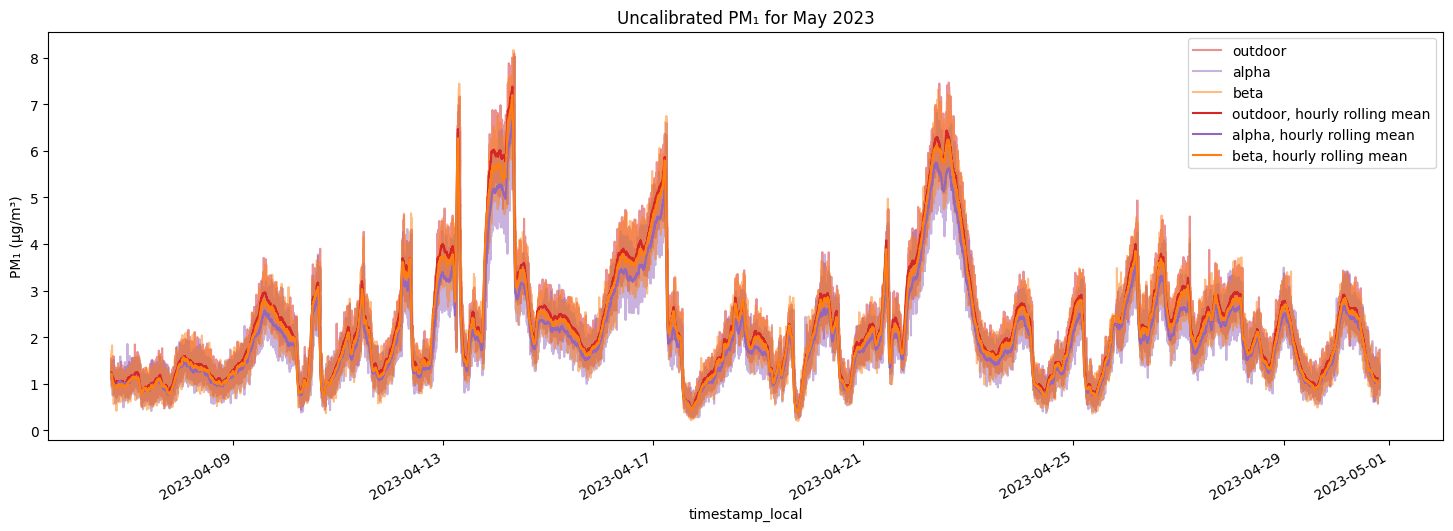

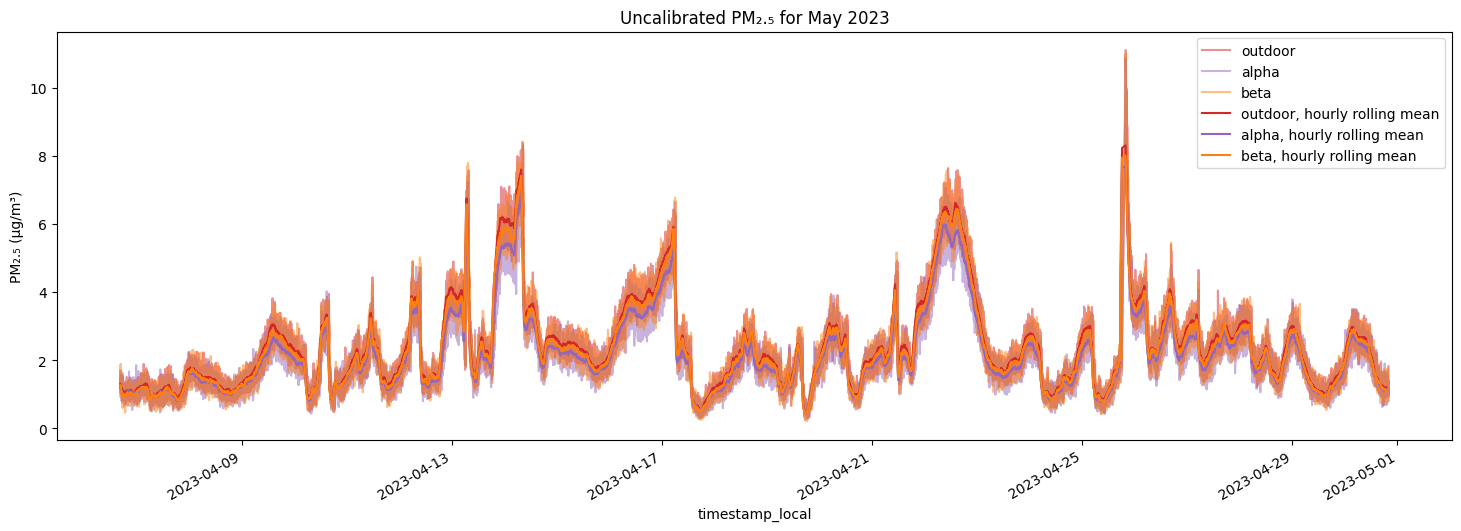

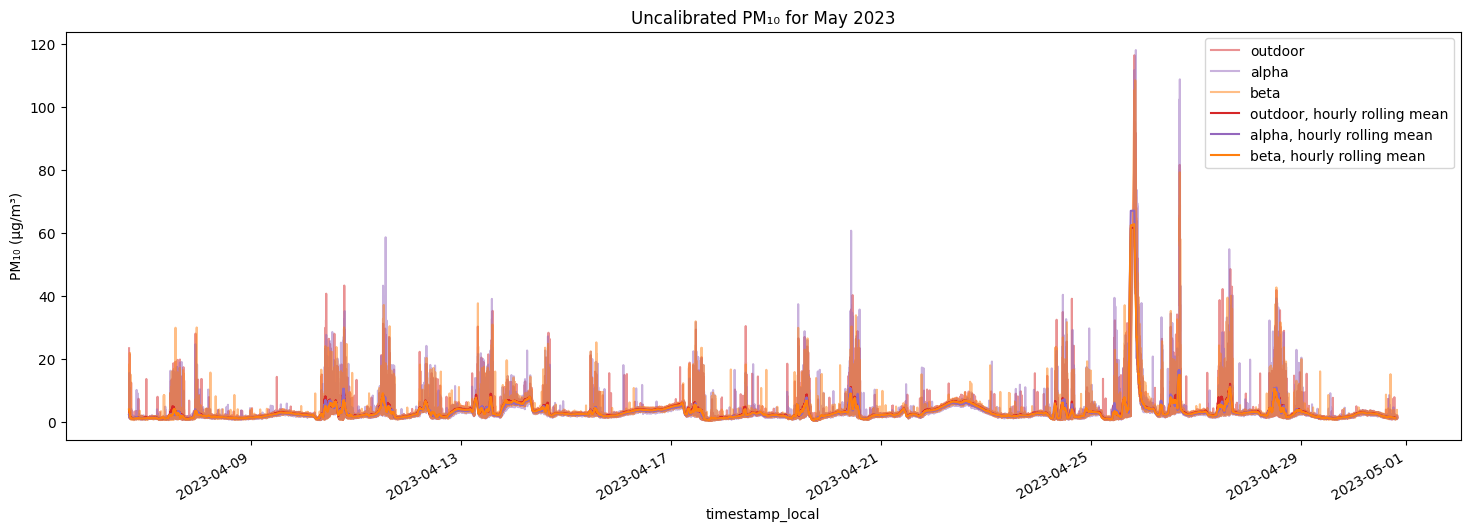

In [115]:
if both_months:
    

    test_dfAlp = OG_dfAlp[test_slice]
    test_dfBet = OG_dfBet[test_slice]
    test_dfMod = OG_dfMod[test_slice]
else:
    test_dfMod = dfMod_april
    test_dfAlp = dfAlp_april
    test_dfBet = dfBet_april

for parameter in parameters[1:4]:
    test_dfMod[f'60 mean {parameter["name"]}']=test_dfMod[parameter['name']].rolling(60).mean()
    test_dfAlp[f'60 mean {parameter["name"]}']=test_dfAlp[parameter['name']].rolling(60).mean()
    test_dfBet[f'60 mean {parameter["name"]}']=test_dfBet[parameter['name']].rolling(60).mean()

    fig = plt.figure()
    ax = plt.subplot(111)
    plt.gcf().set_size_inches(18, 6)
    plt.title(f'Uncalibrated {parameter["label"]} for May 2023')
    plt.ylabel(f'{parameter["label"]} ({parameter["unit"]})')
    plt.xlabel('Time (days)')
    plt.grid(True)
    

   

    test_dfMod[parameter["name"]].plot(color='tab:red', label='outdoor', alpha=0.5)
    test_dfAlp[parameter["name"]].plot(color='tab:purple', label='alpha', alpha=0.5)
    test_dfBet[parameter["name"]].plot(color='tab:orange', label='beta', alpha=0.5)
    test_dfMod[f'60 mean {parameter["name"]}'].plot(color='tab:red', label='outdoor, hourly rolling mean')
    test_dfAlp[f'60 mean {parameter["name"]}'].plot(color='tab:purple', label='alpha, hourly rolling mean')
    test_dfBet[f'60 mean {parameter["name"]}'].plot(color='tab:orange', label='beta, hourly rolling mean')
    plt.legend()

    _, p_value_alpha = stats.ttest_ind(test_dfMod[parameter["name"]], test_dfAlp[parameter["name"]], equal_var=False)
    _, p_value_beta = stats.ttest_ind(test_dfMod[parameter["name"]], test_dfBet[parameter["name"]], equal_var=False)

    print(f"{parameter['label']} P-Value Alpha:", p_value_alpha)
    print(f"{parameter['label']} P-Value Beta:", p_value_beta)



In [116]:
print(test_dfAlp.head())

if log_rh:
    test_dfAlp["log_rh"]=np.log(test_dfAlp["rh"])
    test_dfBet["log_rh"]=np.log(test_dfBet["rh"])
    for parameter in parameters[1:4]:
        test_dfAlp[parameter['name']]=alpha_regressor[parameter['name']].predict(test_dfAlp[[parameter["name"],"temp","log_rh"]])
        test_dfBet[parameter['name']]=beta_regressor[parameter['name']].predict(test_dfBet[[parameter["name"],"temp","log_rh"]])
else:        
    for parameter in parameters[1:4]:
        test_dfAlp[parameter['name']]=alpha_regressor[parameter['name']].predict(test_dfAlp[[parameter["name"],"temp","rh"]])
        test_dfBet[parameter['name']]=beta_regressor[parameter['name']].predict(test_dfBet[[parameter["name"],"temp","rh"]])

                                      timestamp            sn     rh   temp  \
timestamp_local                                                               
2023-04-30 19:59:00+00:00  2023-04-30T23:59:03Z  MOD-PM-00955  41.05  25.48   
2023-04-30 19:58:00+00:00  2023-04-30T23:58:03Z  MOD-PM-00955  41.08  25.48   
2023-04-30 19:57:00+00:00  2023-04-30T23:57:03Z  MOD-PM-00955  41.10  25.47   
2023-04-30 19:56:00+00:00  2023-04-30T23:56:03Z  MOD-PM-00955  41.07  25.47   
2023-04-30 19:55:00+00:00  2023-04-30T23:55:03Z  MOD-PM-00955  40.97  25.47   

                           sample_pres     lat     lon device_state    pm1  \
timestamp_local                                                              
2023-04-30 19:59:00+00:00          0.0  39.956 -75.186       ACTIVE  0.946   
2023-04-30 19:58:00+00:00          0.0  39.956 -75.186       ACTIVE  0.909   
2023-04-30 19:57:00+00:00          0.0  39.956 -75.186       ACTIVE  1.052   
2023-04-30 19:56:00+00:00          0.0  39.956 -75.186  

PM₁ P-Value Alpha: 2.3697813182073595e-46
PM₁ P-Value Beta: 5.42662793167963e-16
PM₂.₅ P-Value Alpha: 4.859190815246602e-38
PM₂.₅ P-Value Beta: 1.7978711081020025e-13
PM₁₀ P-Value Alpha: 9.090980728494735e-16
PM₁₀ P-Value Beta: 4.810610090877432e-22


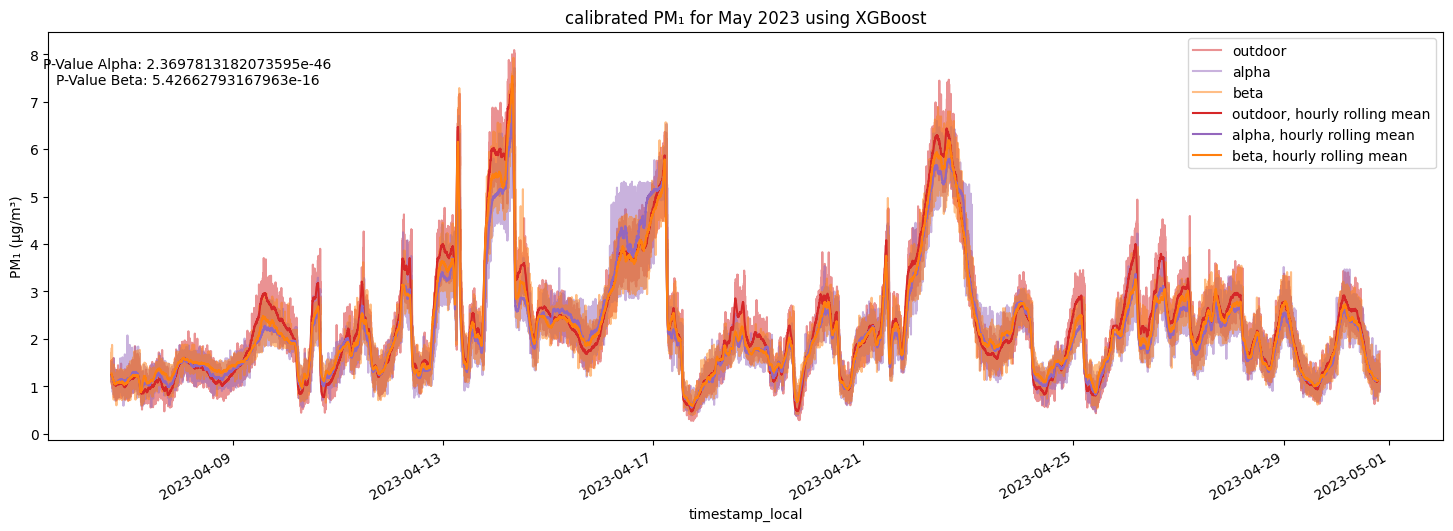

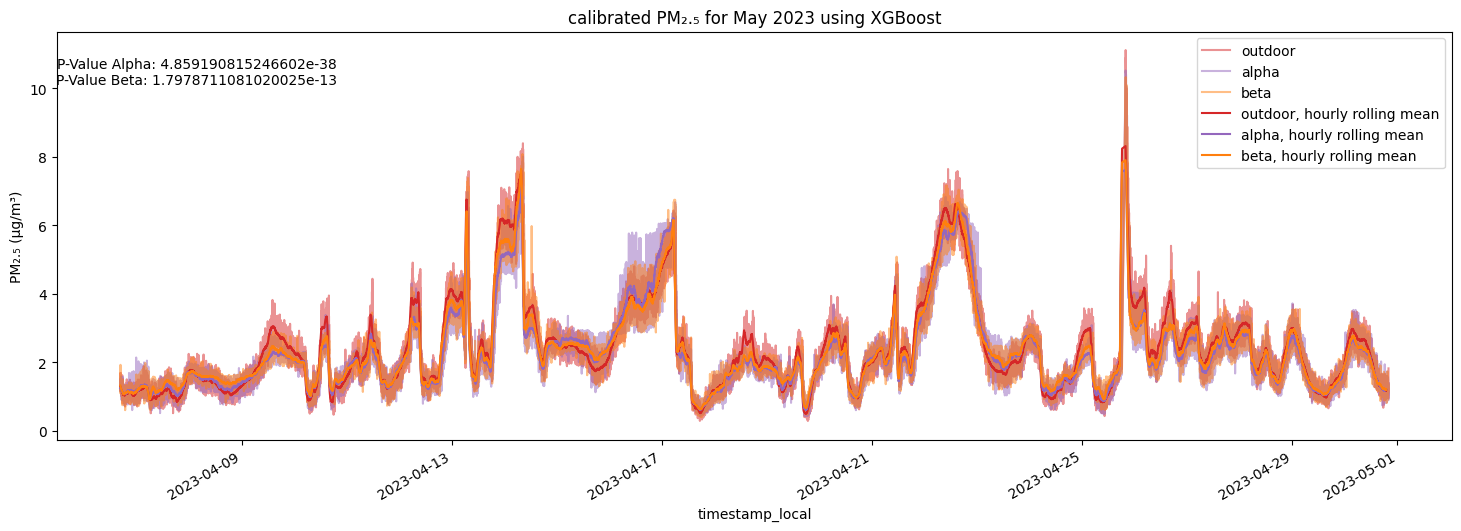

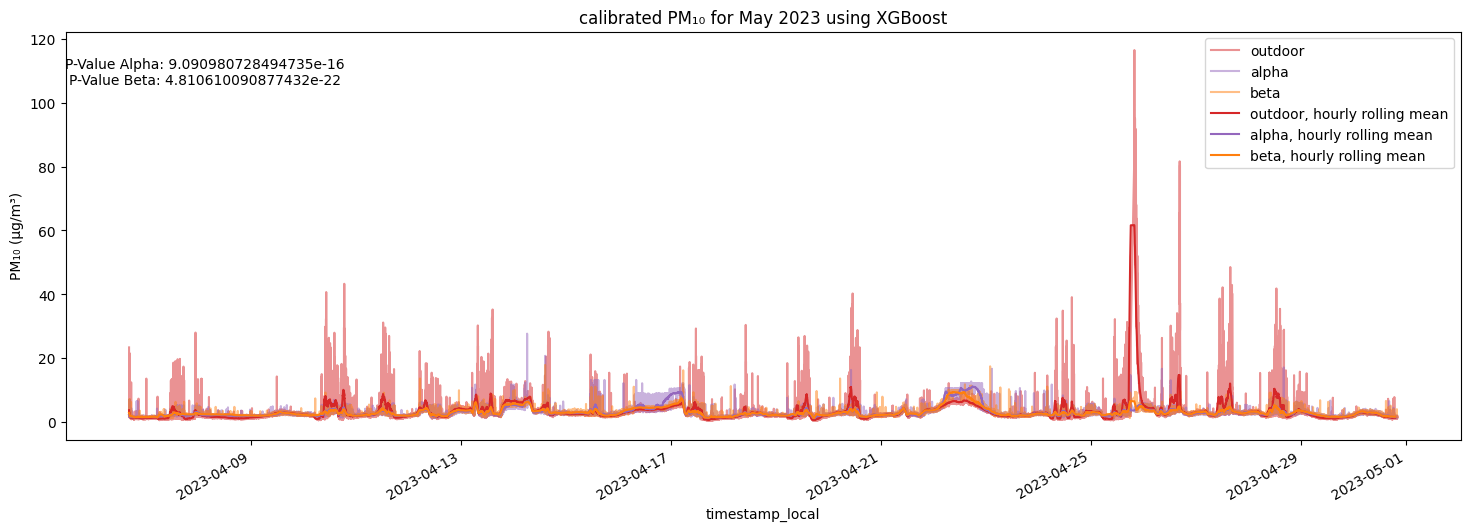

In [117]:
for parameter in parameters[1:4]:
    test_dfMod[f'60 mean {parameter["name"]}']=test_dfMod[parameter['name']].rolling(60).mean()
    test_dfAlp[f'60 mean {parameter["name"]}']=test_dfAlp[parameter['name']].rolling(60).mean()
    test_dfBet[f'60 mean {parameter["name"]}']=test_dfBet[parameter['name']].rolling(60).mean()

    fig = plt.figure()
    ax = plt.subplot(111)
    plt.gcf().set_size_inches(18, 6)
    plt.title(f'calibrated {parameter["label"]} for May 2023 using XGBoost')
    plt.ylabel(f'{parameter["label"]} ({parameter["unit"]})')
    plt.xlabel('Time (days)')
    plt.grid(True)
   
    _, p_value_alpha = stats.ttest_ind(test_dfMod[parameter["name"]], test_dfAlp[parameter["name"]], equal_var=False)
    _, p_value_beta = stats.ttest_ind(test_dfMod[parameter["name"]], test_dfBet[parameter["name"]], equal_var=False)
    plt.text(0.1, 0.9, f'P-Value Alpha: {p_value_alpha}\nP-Value Beta: {p_value_beta}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)

   

    test_dfMod[parameter["name"]].plot(color='tab:red', label='outdoor', alpha=0.5)
    test_dfAlp[parameter["name"]].plot(color='tab:purple', label='alpha', alpha=0.5)
    test_dfBet[parameter["name"]].plot(color='tab:orange', label='beta', alpha=0.5)
    test_dfMod[f'60 mean {parameter["name"]}'].plot(color='tab:red', label='outdoor, hourly rolling mean')
    test_dfAlp[f'60 mean {parameter["name"]}'].plot(color='tab:purple', label='alpha, hourly rolling mean')
    test_dfBet[f'60 mean {parameter["name"]}'].plot(color='tab:orange', label='beta, hourly rolling mean')
    plt.legend()


    print(f"{parameter['label']} P-Value Alpha:", p_value_alpha)
    print(f"{parameter['label']} P-Value Beta:", p_value_beta)

0.981218580523234
1.0109476924215492
0.9821229463798732
1.0125736953208695
1.1956434676354435
1.2129415832604833


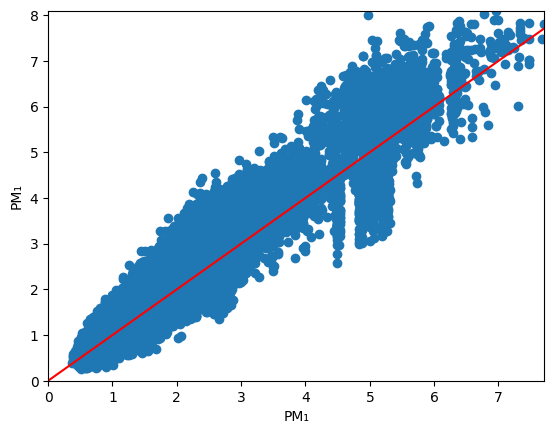

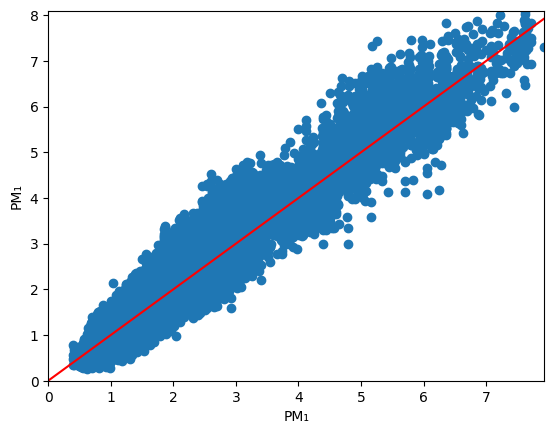

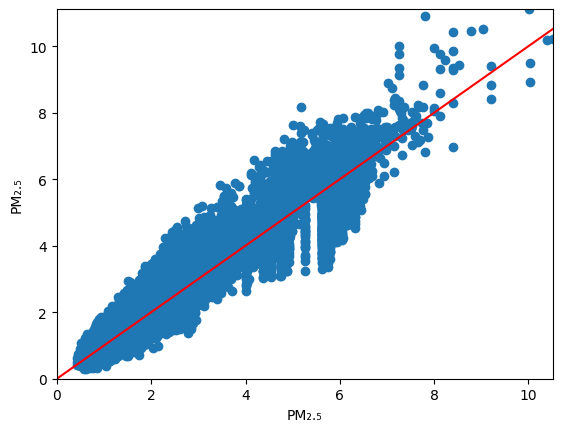

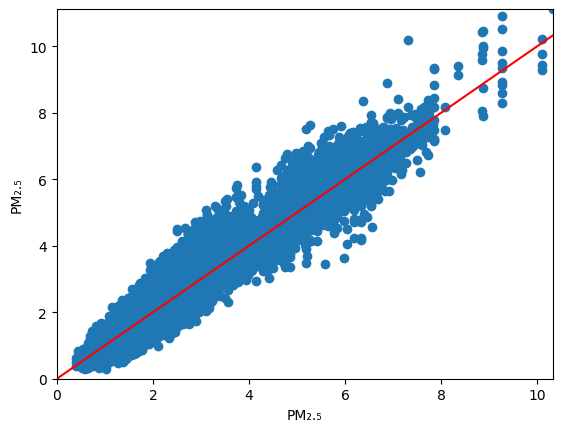

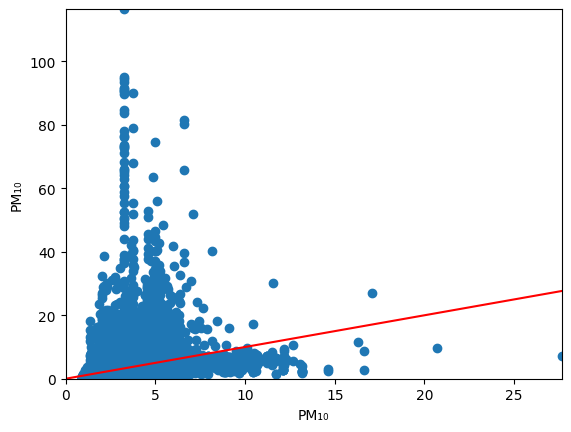

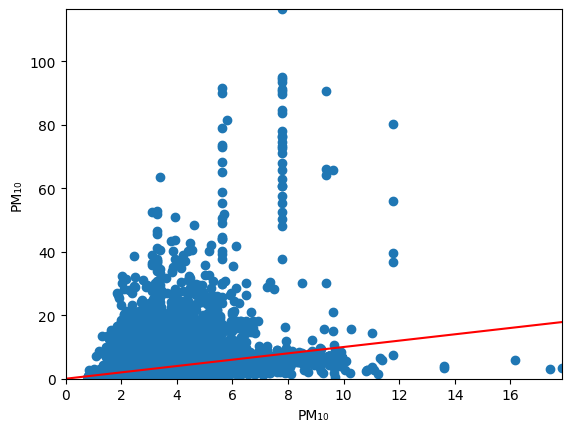

In [118]:

x = np.linspace(0, 100, 1000)
y = np.linspace(0, 100, 1000)

for parameter in parameters[1:4]:
    fig = plt.figure()
    ax = plt.subplot(111)
    
    plt.plot(test_dfAlp[parameter["name"]],test_dfMod[parameter["name"]][:len(test_dfAlp)], 'o', label='Original data')
    plt.plot(x, y, 'r', label='Fitted line')
    
    plt.ylim(0, max(test_dfMod[parameter["name"]][:len(test_dfAlp)]))
    plt.xlim(0, max(test_dfAlp[parameter["name"]]))
    plt.xlabel(parameter["label"])
    plt.ylabel(parameter["label"])

    fig = plt.figure()
    ax = plt.subplot(111)
    
    plt.plot(test_dfBet[parameter["name"]],test_dfMod[parameter["name"]][:len(test_dfBet)], 'o', label='Original data')
    plt.plot(x, y, 'r', label='Fitted line')

    plt.ylim(0, max(test_dfMod[parameter["name"]][:len(test_dfBet)]))
    plt.xlim(0, max(test_dfBet[parameter["name"]]))
    
    
    plt.xlabel(parameter["label"])
    plt.ylabel(parameter["label"])


    
    print(np.mean(test_dfAlp[parameter["name"]][:len(dfAlp)]/test_dfMod[parameter["name"]][:len(dfAlp)]))
    print(np.mean(test_dfBet[parameter["name"]][:len(dfBet)]/test_dfMod[parameter["name"]][:len(dfBet)]))

In [119]:
for parameter in parameters[1:4]:
    print(alpha_regressor[parameter['name']].get_params())
    print(beta_regressor[parameter['name']].get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 60, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel'